# 1. Create Spark Session & Import Libraries

In [1]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, StructType, StructField
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np

findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayBatchProcessing") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 16:40:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 2. Define Schema & Data Preprocessing

In [11]:
schema = StructType([
    StructField("FL_DATE", StringType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("AIRLINE_DOT", StringType(), True),
    StructField("AIRLINE_CODE", StringType(), True),
    StructField("DOT_CODE", IntegerType(), True),
    StructField("FL_NUMBER", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("ORIGIN_CITY", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("DEST_CITY", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), True),
    StructField("DELAY_DUE_NAS", DoubleType(), True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), True)
])

data_path = "flight_data.csv"
df = spark.read.csv(data_path, header=True, schema=schema)

df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))
df.printSchema()
df.show(5, truncate=False)

columns_to_drop = [
    'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
    'DEP_TIME', 'DEP_DELAY',
    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME',
    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
df_cleaned = df.drop(*columns_to_drop)


df_cleaned = df_cleaned.dropna(subset=[
    "ARR_DELAY", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
    "DISTANCE", "ORIGIN", "DEST", "AIRLINE", "AIRLINE_CODE"
])

df_cleaned = df_cleaned.filter((F.col("CRS_ELAPSED_TIME") > 0) & (F.col("CRS_ELAPSED_TIME") < 1000))
df_cleaned = df_cleaned.filter((F.col("DISTANCE") > 0) & (F.col("DISTANCE") < 3000))

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

# 3. Feature Engineering

In [12]:
delay_threshold = 60

df_featured = df_cleaned.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= delay_threshold, 1).otherwise(0))
df_featured = df_featured.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))     # dep hour
df_featured = df_featured.withColumn("DEP_MINUTE", (F.col("CRS_DEP_TIME") % 100).cast("integer"))   # dep minute
df_featured = df_featured.withColumn("ARR_HOUR", (F.col("CRS_ARR_TIME") / 100).cast("integer"))     # arrival hour
df_featured = df_featured.withColumn("ARR_MINUTE", (F.col("CRS_ARR_TIME") % 100).cast("integer"))   # arrival minute
df_featured = df_featured.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_DAY_OF_MONTH", F.dayofmonth(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_WEEK_OF_YEAR", F.weekofyear(F.col("FL_DATE")))
df_featured = df_featured.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))
df_featured = df_featured.withColumn("DISTANCE_PER_MINUTE", F.col("DISTANCE") / (F.col("CRS_ELAPSED_TIME") + 1e-6))


featureCols = [
    "AIRLINE_CODE", "ORIGIN", "DEST",
    "CRS_ELAPSED_TIME", "DISTANCE",
    "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE",
    "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR",
    "IS_WEEKEND", "DISTANCE_PER_MINUTE"
]

featureCols = ["AIRLINE_CODE", "ORIGIN", "DEST", "CRS_ELAPSED_TIME", "DISTANCE", "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE", "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR", "IS_WEEKEND", "DISTANCE_PER_MINUTE"]
labelCol = "SEVERE_DELAY"

final_df = df_featured.select(featureCols + [labelCol])

# 4. Making Visualizations

Plotting with 29207 samples.


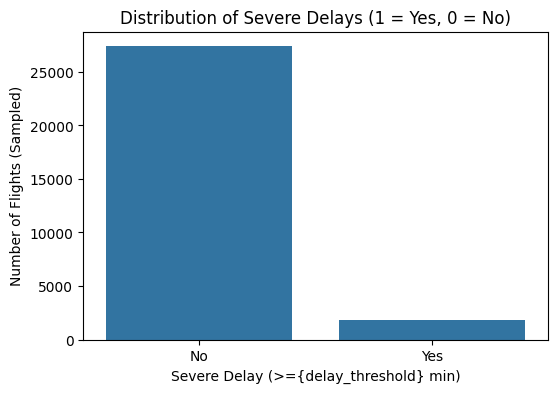

In [13]:
plot_sample_df = final_df.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()
print(f"Plotting with {len(plot_sample_df)} samples.") # doing a sample because it was too large otherwise

# 1. Distribution of Severe Delays
plt.figure(figsize=(6, 4))
sns.countplot(x='SEVERE_DELAY', data=plot_sample_df)
plt.title('Distribution of Severe Delays (1 = Yes, 0 = No)')
plt.xlabel('Severe Delay (>={delay_threshold} min)')
plt.ylabel('Number of Flights (Sampled)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [14]:
# Getting imbalance ratio but using the full dataset for accuracy
target_counts = final_df.groupBy('SEVERE_DELAY').count().toPandas()
print("\nSevere Delay Distribution (Full Data):")
print(target_counts)
if len(target_counts) == 2:
    imbalance_ratio = target_counts['count'].min() / target_counts['count'].max()
    print(f"Imbalance Ratio: {imbalance_ratio:.4f}")

[Stage 15:>                                                         (0 + 8) / 8]


Severe Delay Distribution (Full Data):
   SEVERE_DELAY    count
0             1   178072
1             0  2729891
Imbalance Ratio: 0.0652


Plotting with 29207 samples.


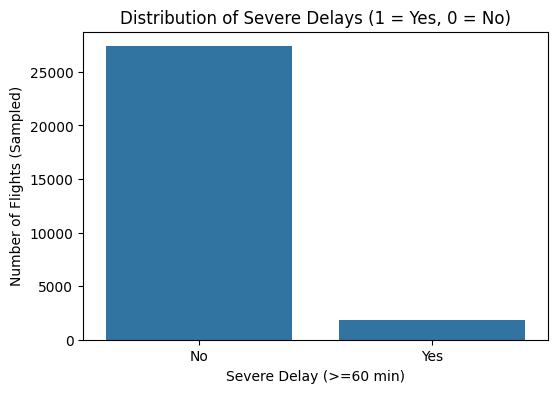


Severe Delay Distribution (Full Data):
   SEVERE_DELAY    count
0             1   178072
1             0  2729891
Imbalance Ratio: 0.0652

Sampling majority class with fraction: 0.1305 to reach desired imbalance ratio 0.5


[Stage 22:============================>                            (8 + 8) / 16]


Balanced dataset has 534174 rows.


In [15]:
# Sample a small fraction for plotting
plot_sample_df = final_df.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()
print(f"Plotting with {len(plot_sample_df)} samples.")

# 1. Distribution of Severe Delays
plt.figure(figsize=(6, 4))
sns.countplot(x='SEVERE_DELAY', data=plot_sample_df)
plt.title('Distribution of Severe Delays (1 = Yes, 0 = No)')
plt.xlabel('Severe Delay (>=60 min)')
plt.ylabel('Number of Flights (Sampled)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# 2. Full Dataset Imbalance Check
target_counts = final_df.groupBy('SEVERE_DELAY').count().toPandas()
print("\nSevere Delay Distribution (Full Data):")
print(target_counts)

if len(target_counts) == 2:
    majority_class_count = target_counts[target_counts['SEVERE_DELAY'] == 0]['count'].values[0]
    minority_class_count = target_counts[target_counts['SEVERE_DELAY'] == 1]['count'].values[0]
    imbalance_ratio = minority_class_count / majority_class_count
    print(f"Imbalance Ratio: {imbalance_ratio:.4f}")

    # OPTIONAL: Adjust the ratio
    desired_ratio = 0.5  # <-- set your desired minority:majority ratio here
    majority_sampling_fraction = (minority_class_count / desired_ratio) / majority_class_count
    majority_sampling_fraction = min(1.0, majority_sampling_fraction)  # prevent oversampling

    print(f"\nSampling majority class with fraction: {majority_sampling_fraction:.4f} to reach desired imbalance ratio {desired_ratio}")

    from pyspark.sql import DataFrame

    majority_df = final_df.filter(F.col('SEVERE_DELAY') == 0).sample(withReplacement=False, fraction=majority_sampling_fraction, seed=42)
    minority_df = final_df.filter(F.col('SEVERE_DELAY') == 1)

    balanced_df = majority_df.union(minority_df)

    # You can now use `balanced_df` for modeling instead of `final_df`
    print(f"\nBalanced dataset has {balanced_df.count()} rows.")
else:
    print("Error: Only one class present.")


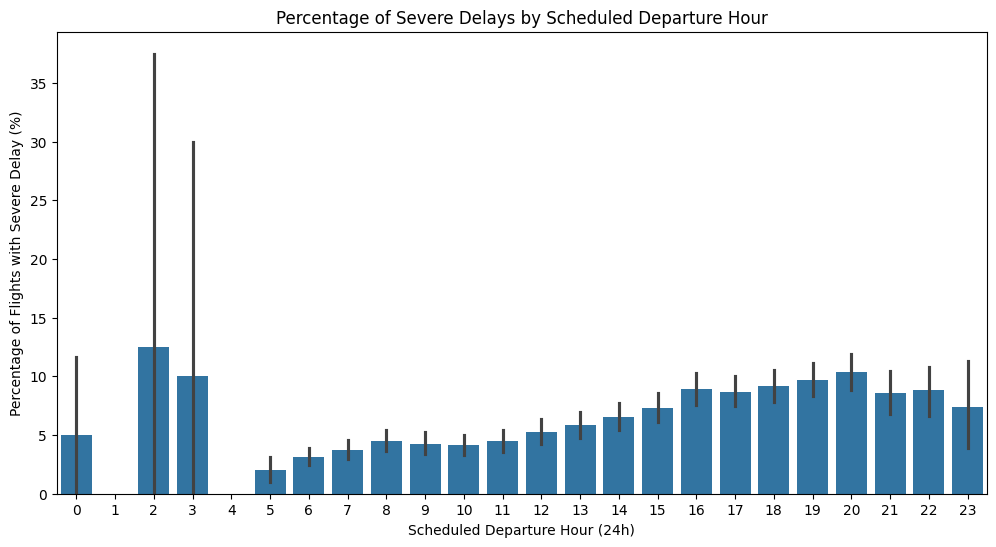

In [16]:
# 2. Barchart of delays by departure hour

plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_HOUR', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Percentage of Severe Delays by Scheduled Departure Hour')
plt.xlabel('Scheduled Departure Hour (24h)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

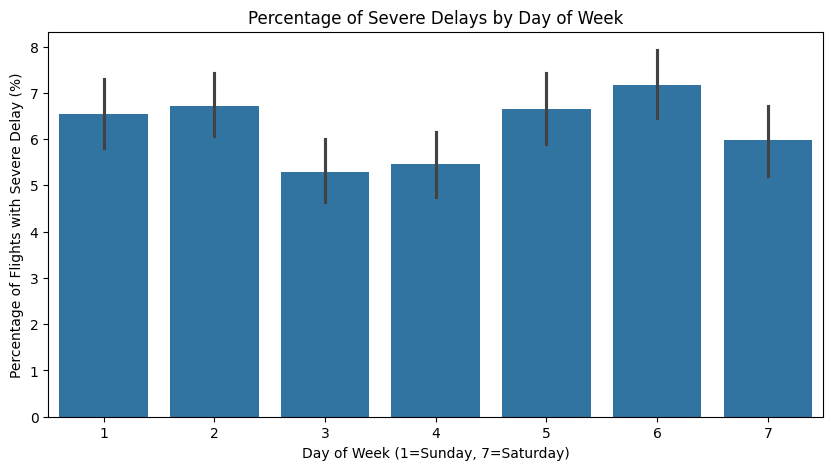

In [17]:
# 3. Delays by Day of the Week

plt.figure(figsize=(10, 5))
sns.barplot(x='DEP_DAY_OF_WEEK', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title(f'Percentage of Severe Delays by Day of Week')
plt.xlabel('Day of Week (1=Sunday, 7=Saturday)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

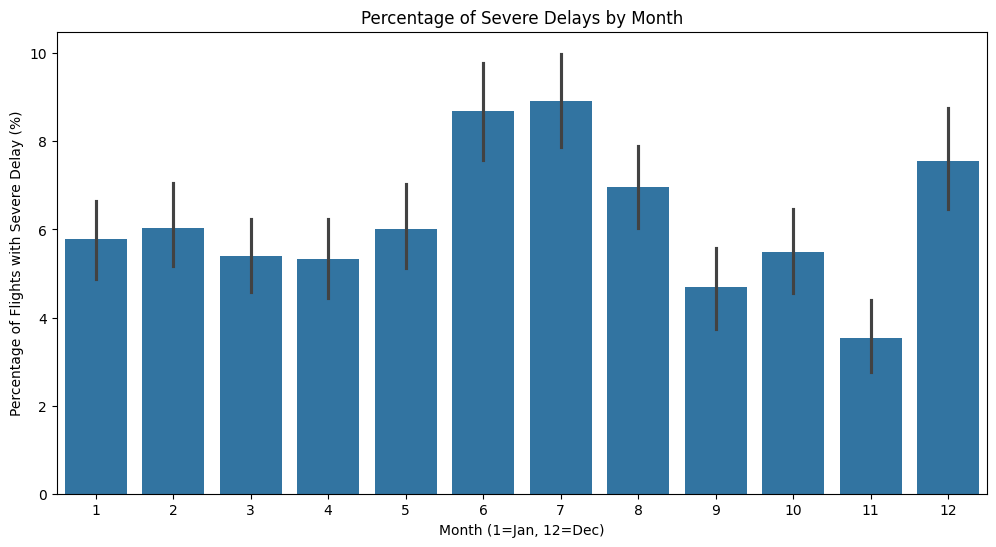

In [18]:
# 4. Delays by Month

plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_MONTH', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title(f'Percentage of Severe Delays by Month')
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

Text(0, 0.5, 'Percentage of Flights with Severe Delay (%)')

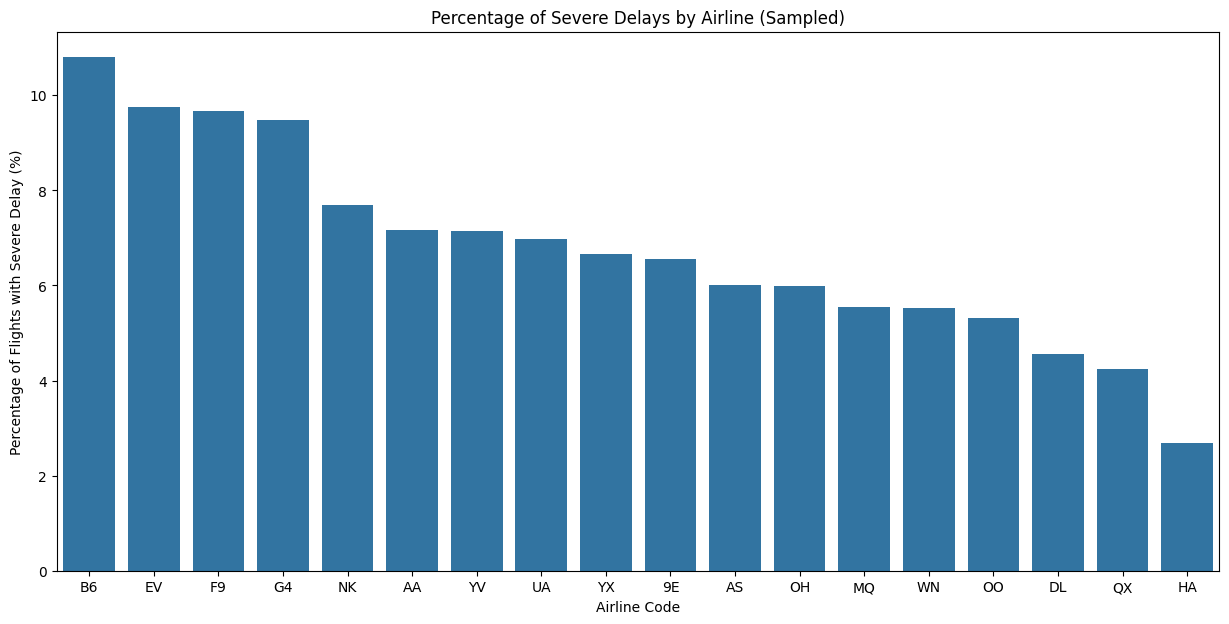

In [19]:
# 5. Top Airlines by Severe Delay Rate (using sampled data)

airline_delay_rate = plot_sample_df.groupby('AIRLINE_CODE')['SEVERE_DELAY'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(15, 7))
sns.barplot(x=airline_delay_rate.index, y=airline_delay_rate.values)
plt.title('Percentage of Severe Delays by Airline (Sampled)')
plt.xlabel('Airline Code')
plt.ylabel('Percentage of Flights with Severe Delay (%)')

Text(0.5, 0, 'Distance (miles)')

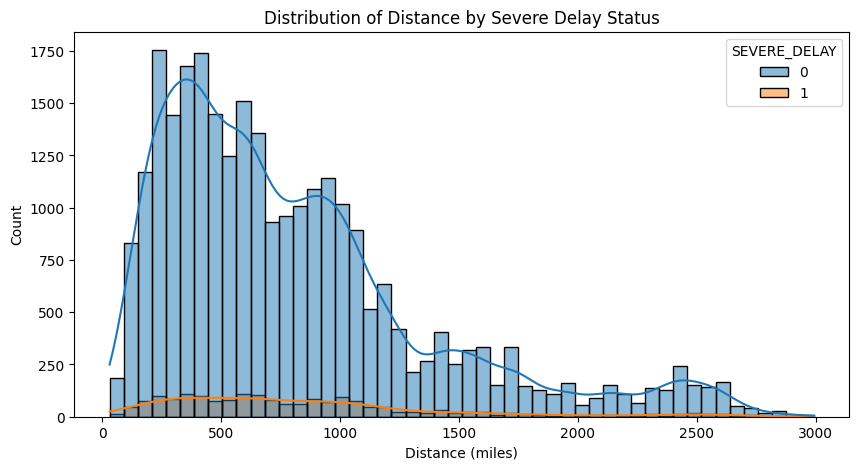

In [20]:
# 6. Numerical Feature Distributions

plt.figure(figsize=(10, 5))
sns.histplot(data=plot_sample_df, x='DISTANCE', hue='SEVERE_DELAY', kde=True, bins=50)
plt.title('Distribution of Distance by Severe Delay Status')
plt.xlabel('Distance (miles)')

# THIS IS WHERE OUR MODELING STUFF STARTS
## YOU CAN RUN THIS INDEPENDENTLY OF ALL EDA ABOVE
## THIS HAS LABELED STEPS FOR EVERYTHING

In [1]:
# 1. Import Libraries and Create Spark Session
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, StructType, StructField
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.mllib.evaluation import MulticlassMetrics

findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayBatchProcessing") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 16:16:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:

# 2. Define Schema & Read Data
schema = StructType([
    StructField("FL_DATE", StringType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("AIRLINE_DOT", StringType(), True),
    StructField("AIRLINE_CODE", StringType(), True),
    StructField("DOT_CODE", IntegerType(), True),
    StructField("FL_NUMBER", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("ORIGIN_CITY", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("DEST_CITY", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), True),
    StructField("DELAY_DUE_NAS", DoubleType(), True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), True)
])

data_path = "flight_data.csv"
df = spark.read.csv(data_path, header=True, schema=schema)

# 3. Cleaning: Drop Irrelevant Fields
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))
columns_to_drop = ['AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
    'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
df_cleaned = df.drop(*columns_to_drop)

# 4. Drop Nulls
df_cleaned = df_cleaned.dropna(subset=["ARR_DELAY", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "ORIGIN", "DEST", "AIRLINE", "AIRLINE_CODE"])

# 5. Outlier Handling
df_cleaned = df_cleaned.filter((F.col("CRS_ELAPSED_TIME") > 0) & (F.col("CRS_ELAPSED_TIME") < 1000))
df_cleaned = df_cleaned.filter((F.col("DISTANCE") > 0) & (F.col("DISTANCE") < 3000))

# 6. Feature Engineering
delay_threshold = 60

df_featured = df_cleaned.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= delay_threshold, 1).otherwise(0))
df_featured = df_featured.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))
df_featured = df_featured.withColumn("DEP_MINUTE", (F.col("CRS_DEP_TIME") % 100).cast("integer"))
df_featured = df_featured.withColumn("ARR_HOUR", (F.col("CRS_ARR_TIME") / 100).cast("integer"))
df_featured = df_featured.withColumn("ARR_MINUTE", (F.col("CRS_ARR_TIME") % 100).cast("integer"))
df_featured = df_featured.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_DAY_OF_MONTH", F.dayofmonth(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_WEEK_OF_YEAR", F.weekofyear(F.col("FL_DATE")))
df_featured = df_featured.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1,7]), 1).otherwise(0))
df_featured = df_featured.withColumn("DISTANCE_PER_MINUTE", F.col("DISTANCE")/(F.col("CRS_ELAPSED_TIME")+1e-6))

featureCols = ["AIRLINE_CODE", "ORIGIN", "DEST", "CRS_ELAPSED_TIME", "DISTANCE", "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE", "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR", "IS_WEEKEND", "DISTANCE_PER_MINUTE"]
labelCol = "SEVERE_DELAY"

final_df = df_featured.select(featureCols + [labelCol])

# 7. Build Preprocessing Pipeline
categorical_cols = ["AIRLINE_CODE", "ORIGIN", "DEST"]
numerical_cols = [col for col in featureCols if col not in categorical_cols]

indexers = [StringIndexer(inputCol=col, outputCol=col+'Index', handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+'Index', outputCol=col+'OHE') for col in categorical_cols]
num_vector_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="NumFeatures")
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True, withMean=True)
final_vector_assembler = VectorAssembler(inputCols=[col+'OHE' for col in categorical_cols] + ["ScaledNumFeatures"], outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [num_vector_assembler, scaler, final_vector_assembler])
pipeline_model = pipeline.fit(final_df)
processed_df = pipeline_model.transform(final_df)


25/04/28 16:16:46 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
                                                                                

In [3]:

# 8. Train/Test Split
model_data = processed_df.select("features", labelCol).withColumnRenamed(labelCol, "label")
train_df, test_df = model_data.randomSplit([0.8, 0.2], seed=101)
train_df_sampled = train_df.sample(withReplacement=False, fraction=0.3, seed=101)


# 9. Handle Class Imbalance
train_df_weighted = train_df_sampled.withColumn("classWeightCol", when(col("label") == 0, 0.2).otherwise(1.0))


In [4]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=30, maxDepth=5, seed=101)
rf_model = rf.fit(train_df_weighted)

In [5]:

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=30, regParam=0.1, elasticNetParam=0.8)
lr_model = lr.fit(train_df_weighted)

25/04/28 16:17:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/28 16:17:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

In [6]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", weightCol="classWeightCol", maxIter=50, maxDepth=5, stepSize=0.1, seed=101)
gbt_model = gbt.fit(train_df_weighted)

25/04/28 16:18:46 WARN BlockManager: Asked to remove block rdd_217_1, which does not exist
25/04/28 16:18:46 WARN BlockManager: Asked to remove block rdd_217_0, which does not exist
25/04/28 16:18:46 WARN BlockManager: Asked to remove block rdd_217_7, which does not exist
                                                                                

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Random Forest Evaluation:
AUC: 0.6290
Accuracy: 0.9388
Precision: 0.8813
Recall: 0.9388
F1 Score: 0.9091


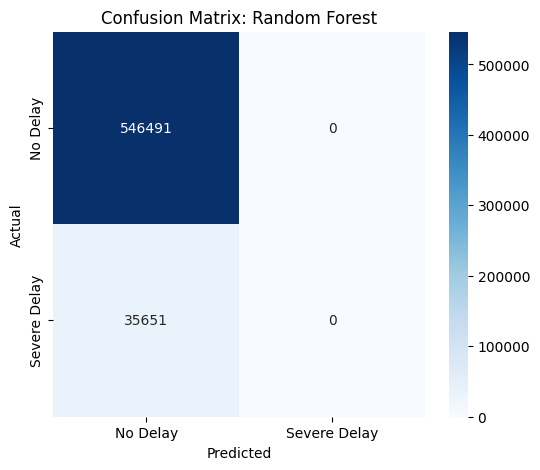

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Logistic Regression Evaluation:
AUC: 0.5000
Accuracy: 0.9388
Precision: 0.8813
Recall: 0.9388
F1 Score: 0.9091


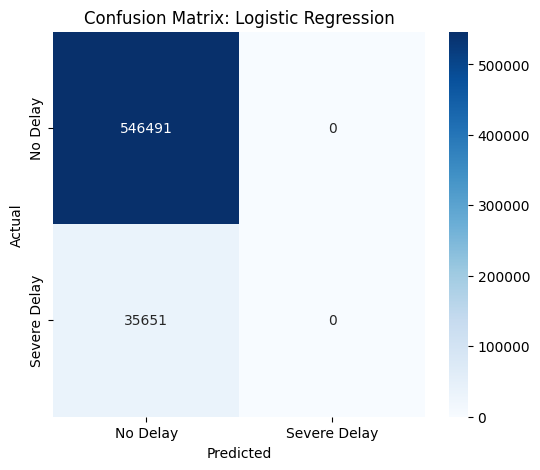

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



GBT Evaluation:
AUC: 0.6783
Accuracy: 0.9286
Precision: 0.8983
Recall: 0.9286
F1 Score: 0.9104


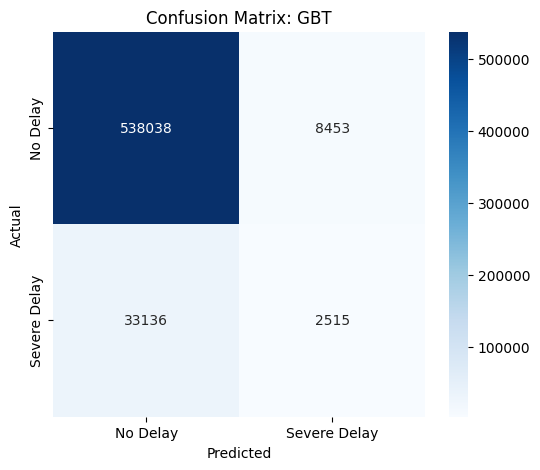

In [7]:
# 11. Evaluate Models
models = {"Random Forest": rf_model, "Logistic Regression": lr_model, "GBT": gbt_model}

for model_name, model in models.items():
    predictions = model.transform(test_df)
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
    auc = evaluator.evaluate(predictions)

    evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
    precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
    recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)
    f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)

    print(f"\n{model_name} Evaluation:")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
    metrics = MulticlassMetrics(preds_and_labels)
    cm = metrics.confusionMatrix().toArray()

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=["No Delay", "Severe Delay"],
                yticklabels=["No Delay", "Severe Delay"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [12]:
# Save GBT Model and Pipeline
pipeline_path = "./flight_delay_gbt_pipeline_model"
model_path = "./flight_delay_gbt_model"

pipeline_model.write().overwrite().save(pipeline_path)  # This saves the preprocessing pipeline
gbt_model.write().overwrite().save(model_path)          # <-- Save GBT model here!

spark.stop()
print("\nSpark Session Stopped.")



Spark Session Stopped.
